# Online surveillance and Wikipedia use

Our 3 research questions are the following:
- Can we observe chilling effects on Wikipedia access data even if we use a longer time frame for the analysis?
- Are there chilling effects on Wikipedia accross different languages?
- Can we observe chilling effects on Google Trends as well?

In order to answer them, we need to retrieve access data from Wikipedia and Google Trends.

For Wikipedia, we use the R library `wikipediatrend` which allows to collect pageviews for different languages and over a long period of time.
A notable flaw with this library is that it uses two different APIs to retrieve data:
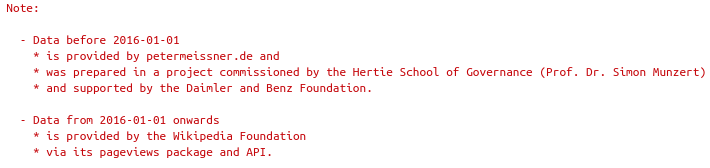
However, this is due to the fact that the official API to retrieve Wikipedia pageviews only appeared in January 2016, so this is a problem we couldn't overcome.
Thus, we had to limit our extended analysis to end on December 2015 in order to get unbiased results.

We define thus two time ranges: the reduced one, used in the paper, from January 2012 to August 2014, and the extended one, from January 2010 to December 2015.

Inside the `utils` folder, we have the R script `translating_topics.R` which allowed us to translate the Wikipedia article names for the set of 30 terrorism-related and 25 domestic security-related articles to German, French, Italian, Spanish and Portuguese, and then we retrieved the pageviews for the articles in all these languages using `scrapping_wikipedia.R`.
An important point to take into account is that some of the Wikipedia articles mentioned in the paper changed name or were merged with others (namely suicide_bomber and suicide_attack were grouped together under the latter's name), and as such we do not have exactly the same groups of articles as in the paper.

For Google Trends, we use the `GTAB` library from the `DLAB` to query the interest of Google users in different search terms later on in the notebook. For the purpose of data scraping and wrangling we have also defined a helper class `TrendsQuerier` inside the file `utils/query_google.py`.

## Imports & Constants

In [1]:
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import seaborn as sns
import statsmodels.formula.api as smf

from utils.query_google import TrendsQueryer
from utils.plotly_plots import analyse_and_plot, four_panel_pageviews_plot, four_panel_google_plot

In [2]:
def install_requirements():
    import sys
    !{sys.executable} -m pip install gtab  # Has to be checked first or else gtab is imported as module from the data folder gtab
    !{sys.executable} -m pip install jupyter-dash
    !{sys.executable} -m pip install plotly
    !{sys.executable} -m pip install psutil
    !{sys.executable} -m pip install jupyterlab "ipywidgets>=7.5"

In [3]:
import plotly.offline as pyo
pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
import gtab
# install_requirements()

In [5]:
PRISM_DATE = datetime.datetime(2013, 6, 6)

# GTAB information
TIMEFRAME = '2011-01-01 2015-12-31'
GEO_CODES = ['', 'ar', 'de', 'es', 'fr', 'hi', 'it', 'ja', 'pt', 'ru']

GOOGLE_DATA = 'data/google-trends'
WIKI_DATA = 'data/wikipedia'

PAPER_TIME_RANGE = [datetime.datetime(2012, 1, 1), datetime.datetime(2014, 8, 31)]
WIKI_API_CHANGE = datetime.datetime(2015, 12, 31)

In [6]:
wiki_layout = {'yaxis_title': 'Cumulated page views', 'xaxis_title': 'Month'}
google_layout = {'yaxis_title': 'Cumulated Google Trends Rating', 'xaxis_title': 'Month'}

## Querying Google Trends

Using our prepared utility functions to query relevant keywords from google trends, using the dlabs GTAB library.

In [7]:
all_google_trends = {}
gt = TrendsQueryer(TIMEFRAME, geo_code='')
gt_terror = gt.load_or_query('terrorism_en')
gt_domestic = gt.load_or_query('domestic_en')

Directory already exists, loading data from it.
Using directory '/home/jonathan/Documents/ada-2020-project-milestone-p3-p3_0x414441/gtab/'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=_timeframe=2011-01-01 2015-12-31.tsv

Loaded terrorism_en.csv
Loaded domestic_en.csv


In [8]:
gt_terror.sample(frac=1).head()

article        date  max_ratio  max_ratio_hi  max_ratio_lo  \
2927   Eco-terrorism  2012-01-29   0.000000      0.000203      0.000000   
2641      Dirty bomb  2011-08-07   0.072464      0.080292      0.064748   
10386        nuclear  2014-12-21   5.792226      7.267626      4.492877   
1909        Car bomb  2012-07-29   0.276596      0.290323      0.263158   
31        Abu Sayyaf  2011-08-07   0.040000      0.045000      0.035000   

      lanuage  
2927   en.csv  
2641   en.csv  
10386  en.csv  
1909   en.csv  
31     en.csv

For every search term to analyze, Google Trends usually returns a time series of interest in this search term, scaled to the range [0, 100]. This is usefull if one is looking for the relative interest in a specific term over time. However, it is hard to compare the results for different terms, as the maximum amount of queried search terms at a time is 5. To compare more than 5 keywords using Google Trends, one has to query the API multiple times, with each result being auto-scaled. The GTAB library solves this problem by scaling each time series based on an anchorbank that is used to calibrate individual results. The resulting max_ratio can be seen as a scaled interest value for a certain keyword. For more details, we refer to [the according paper](https://arxiv.org/pdf/2007.13861.pdf), published in September 2020.

#### Concatenate the dataframes to one:

In [9]:
# Concatenate the dataframes into one
gt_terror['topic'] = 'terror'
gt_domestic['topic'] = 'domestic'
google = pd.concat([gt_terror, gt_domestic])
# Create a column that simplifies the month and only leaves the month
google['date'] = pd.to_datetime(google['date'])
google['month'] = google.date.dt.to_period('M')

# Wikipedia

## Understanding the Wikipedia Data

The first thing that we want to do to understand our data is to plot the total number of pageviews per month per article.

In [10]:
# Read both csv files
df_terrorism = pd.read_csv(f'data/wikipedia/terrorism_views.csv')
df_domestic = pd.read_csv(f'data/wikipedia/domestic_views.csv')

# Group them
df = pd.concat([df_terrorism, df_domestic])

# Create a mapping from article name to study group
group = {}
for article in df_terrorism.article.unique():
    group[article] = 'terrorism'
for article in df_domestic.article.unique():
    group[article] = 'domestic'


# We extract the month, year, time (number of months elapsed since the beginning of the period)
df['month'] = pd.DatetimeIndex(df.date).month
df['year'] = pd.DatetimeIndex(df.date).year
df['time'] = (df.year - df.year.min()) * 12 + df.month


# Get the total number of views for each article for each month
monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index()\
                              .pivot_table(index='article', columns='time', values='views')

# Retrieve the monthly pageviews for each article group
terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]

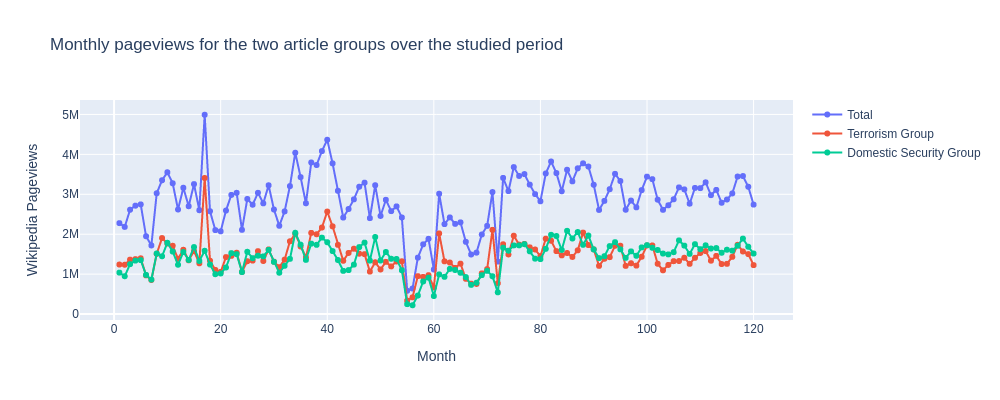

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_views.sum().index, y=monthly_views.sum().values, name="Total", mode='lines+markers'))
fig.add_trace(go.Scatter(x=terrorism_views.sum().index, y=terrorism_views.sum().values, name="Terrorism Group", mode='lines+markers'))
fig.add_trace(go.Scatter(x=domestic_views.sum().index, y=domestic_views.sum().values, name="Domestic Security Group", mode='lines+markers'))
fig.update_layout(title='Monthly pageviews for the two article groups over the studied period', xaxis_title='Month', yaxis_title='Wikipedia Pageviews', width=1000, height=750)
fig.show('png', width=1000, height=400)

We can see a strange drop of pageviews around month 55 (July 2014), let's try to understand it.

### Strange pageview drop around month 55

In [12]:
# We count the number of zeros for each article for each month
df['zeros'] = (df['views'] == 0).astype(int)
zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index().pivot_table(index='article', columns='time', values='zeros')

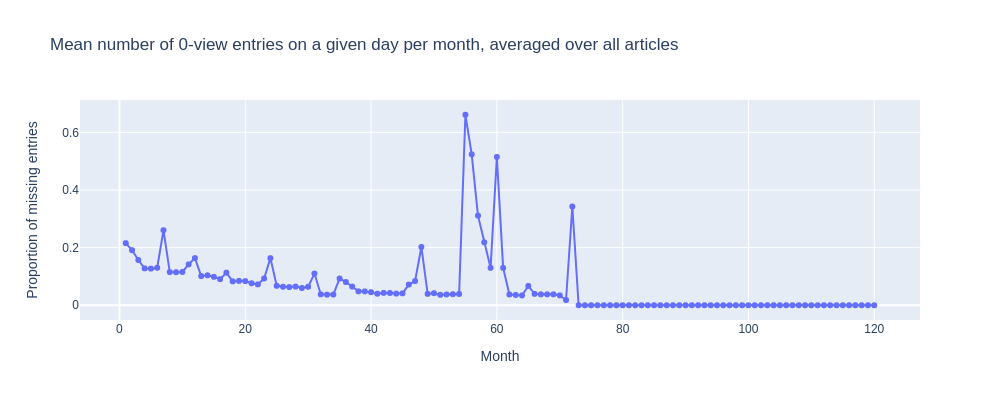

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=zeroes.mean().index, y=zeroes.mean().values, name="Proportion of missing entries", mode='lines+markers'))
fig.update_layout(xaxis_title='Month', yaxis_title='Proportion of missing entries', title='Mean number of 0-view entries on a given day per month, averaged over all articles', width=1000, height=750)
fig.show('png', width=1000, height=400)

This sudden increase in missing entries might be due to a Wikipedia outage during the months 54 to 60 (June to December 2014), or due to the unofficial API not having complete data for these months.

In any case, we will not consider these months during our ITS analysis as this would surely affect the results. To do so, in the regression we will simply drop the entries corresponding to the mentioned months, without shifting the month numbers after them.

### Looking for outliers

As in the original paper, many of the articles see sudden spikes in pageviews for some months, likely due to mediatized events such as conflicts.

In order to reduce the effects of sudden events like this and to focus only on the relevant trends, we will hunt down potential outliers and remove them from our analysis.

In [14]:
# This is a dictionary from languages to the corresponding DataFrame of monthly views per article
views = {lang: df[df.language == lang].groupby(['article', 'time'])['views'].sum().reset_index() for lang in df.language.unique()}

In [15]:
# This is a dictionary from language to list of outlier articles
outliers = {}

#### English

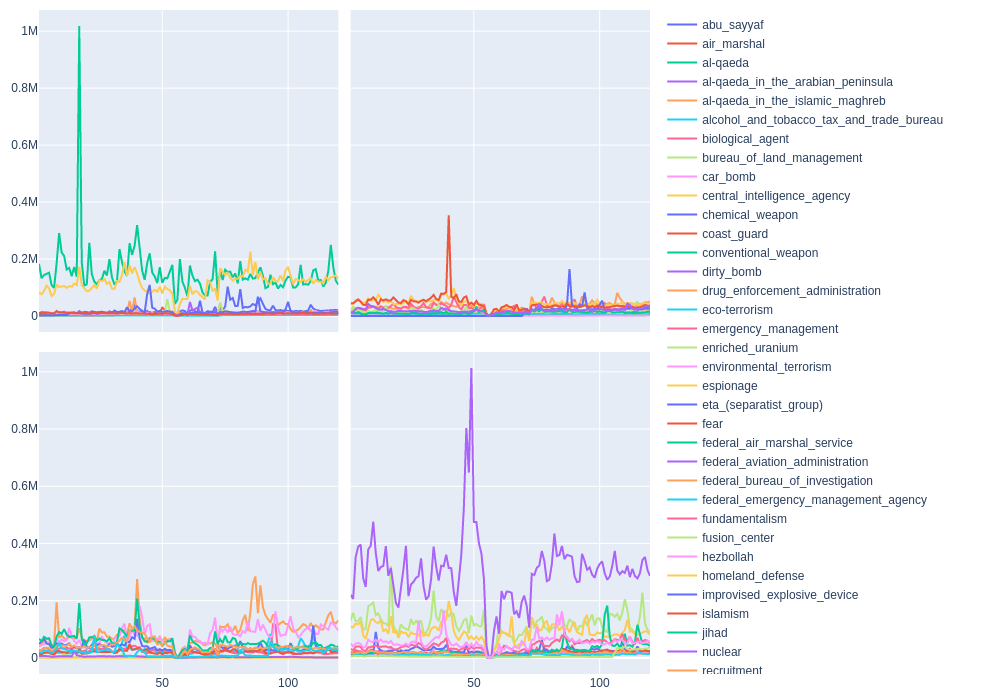

In [16]:
lang = 'en'
four_panel_pageviews_plot(views[lang], lang)

In [17]:
outliers[lang] = ['al-qaeda', 'united_nations', 'fear']

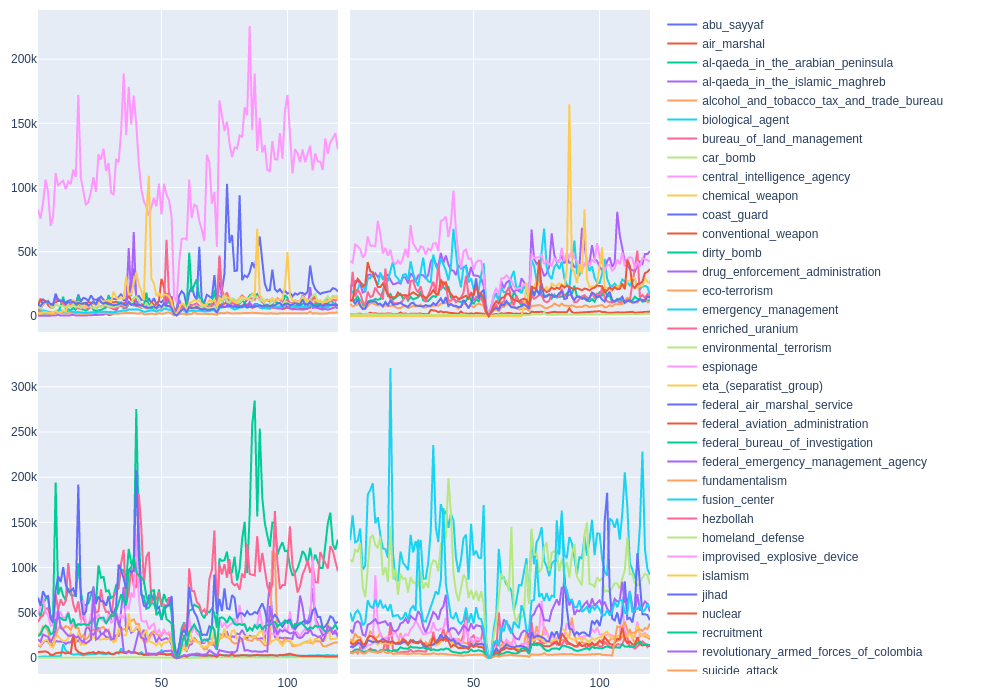

In [18]:
four_panel_pageviews_plot(views[lang], outliers[lang])

#### German

In [19]:
outliers[lang] = ['al-qaida', 'vereinte_nationen', 'islamismus', 'farc-ep']

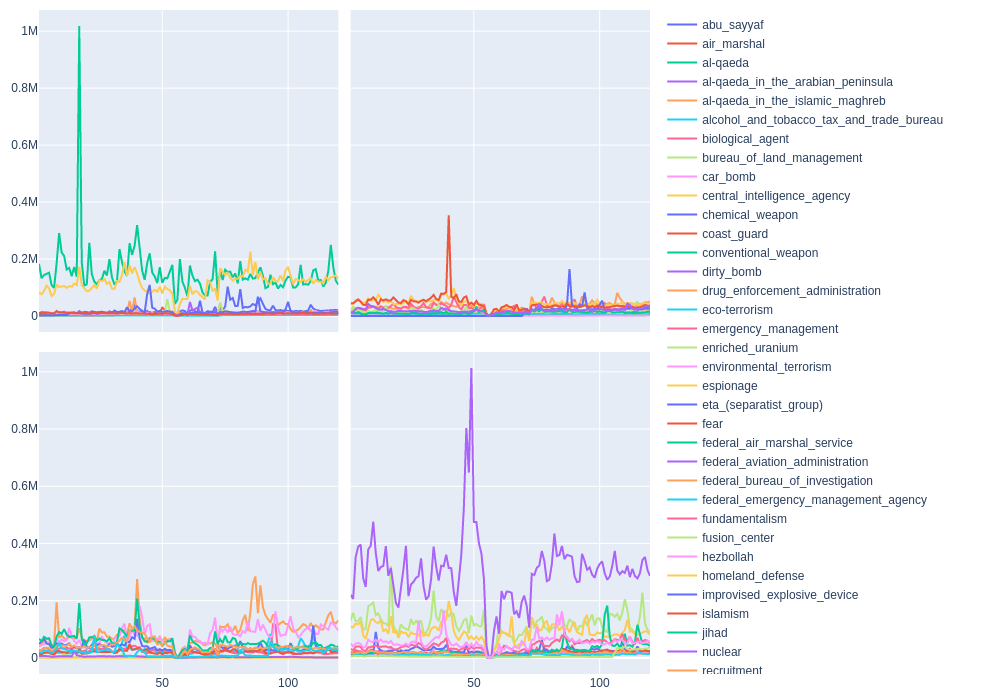

In [20]:
four_panel_pageviews_plot(views[lang], outliers[lang])

#### French

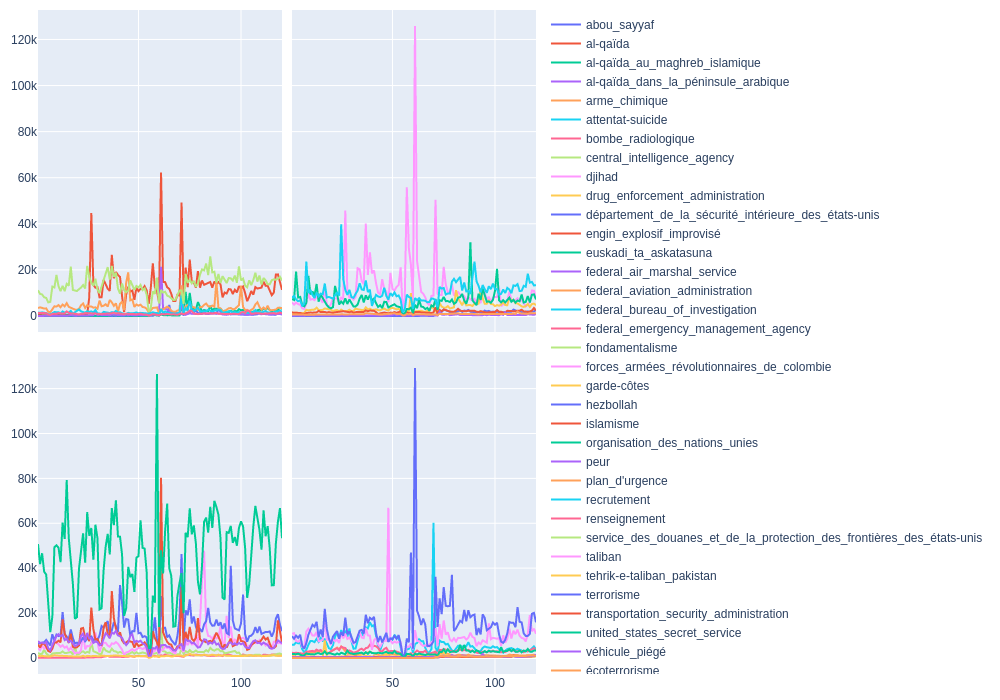

In [21]:
lang = 'fr'
four_panel_pageviews_plot(views[lang])

In [22]:
outliers[lang] = ['al-qaïda', 'djihad', 'islamisme', 'terrorisme', 'organisation_des_nations_unies', 'taliban', 'recrutement']

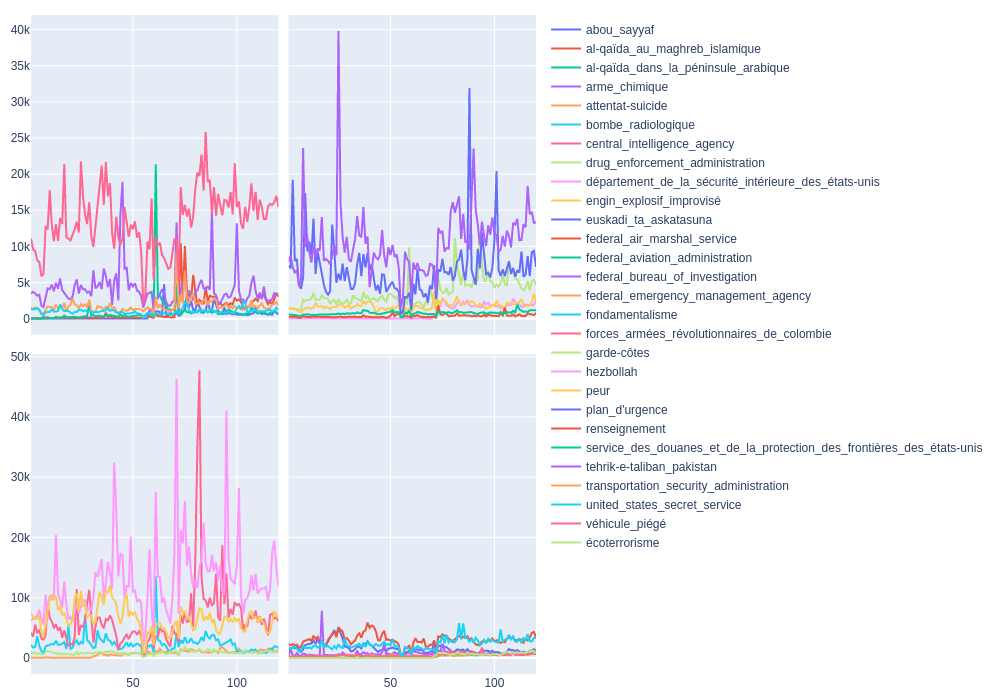

In [23]:
four_panel_pageviews_plot(views[lang], outliers[lang])

#### Spanish

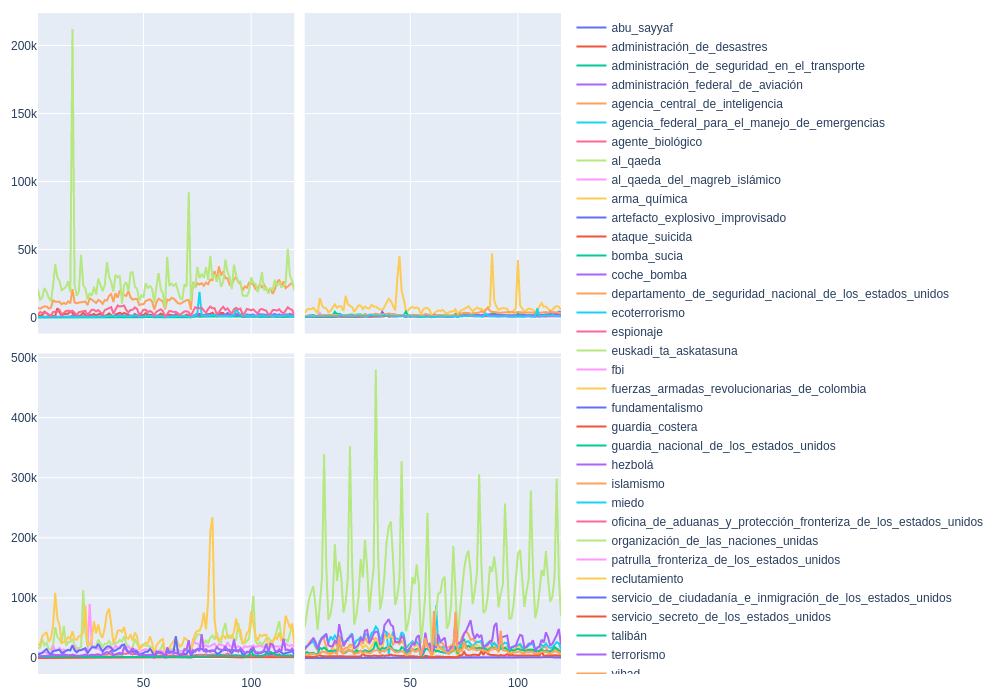

In [24]:
lang = 'es'
four_panel_pageviews_plot(views[lang])

In [25]:
outliers[lang] = ['al_qaeda', 'arma_química', 'fuerzas_armadas_revolucionarias_de_colombia', 'organización_de_las_naciones_unidas']

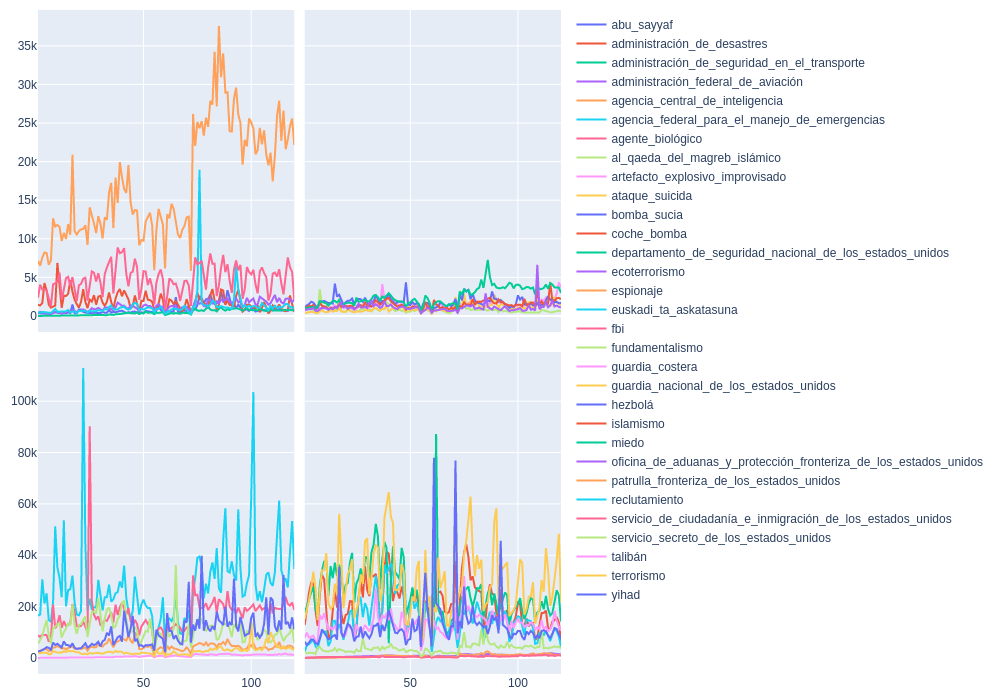

In [26]:
four_panel_pageviews_plot(views[lang], outliers[lang])

#### Italian

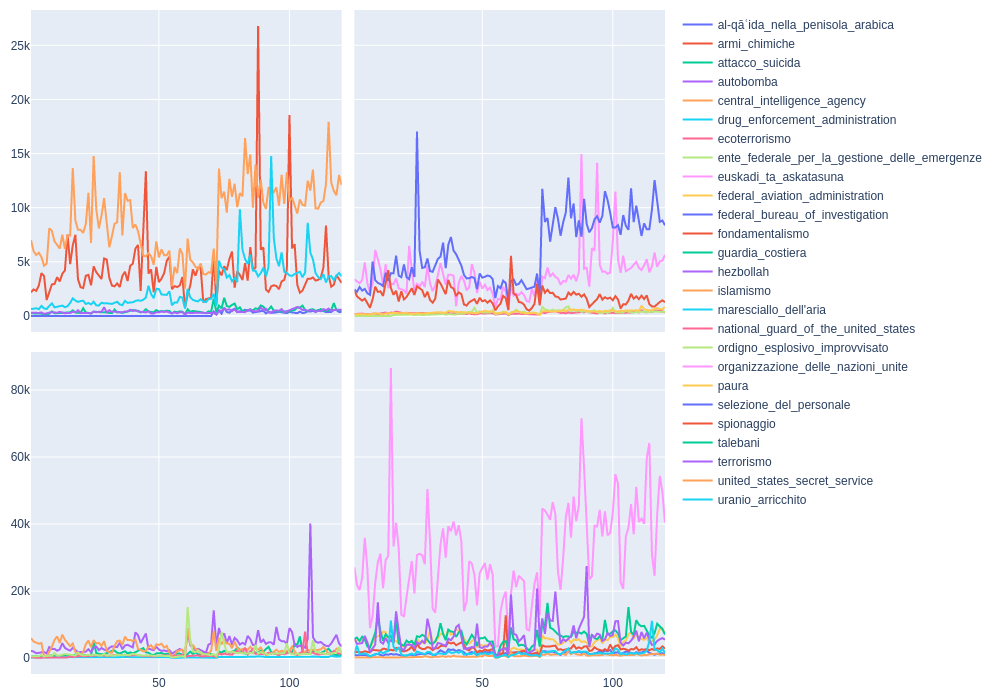

In [27]:
lang = 'it'
four_panel_pageviews_plot(views[lang])

In [28]:
outliers[lang] = ['armi_chimiche', 'organizzazione_delle_nazioni_unite', 'hezbollah']

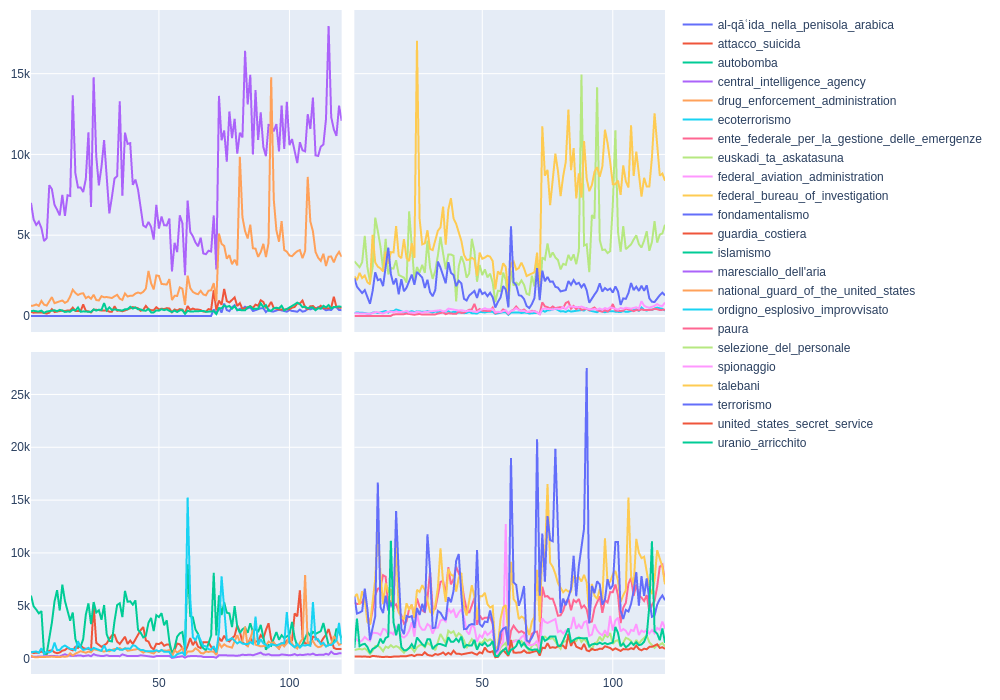

In [29]:
four_panel_pageviews_plot(views[lang], outliers[lang])

#### Portuguese

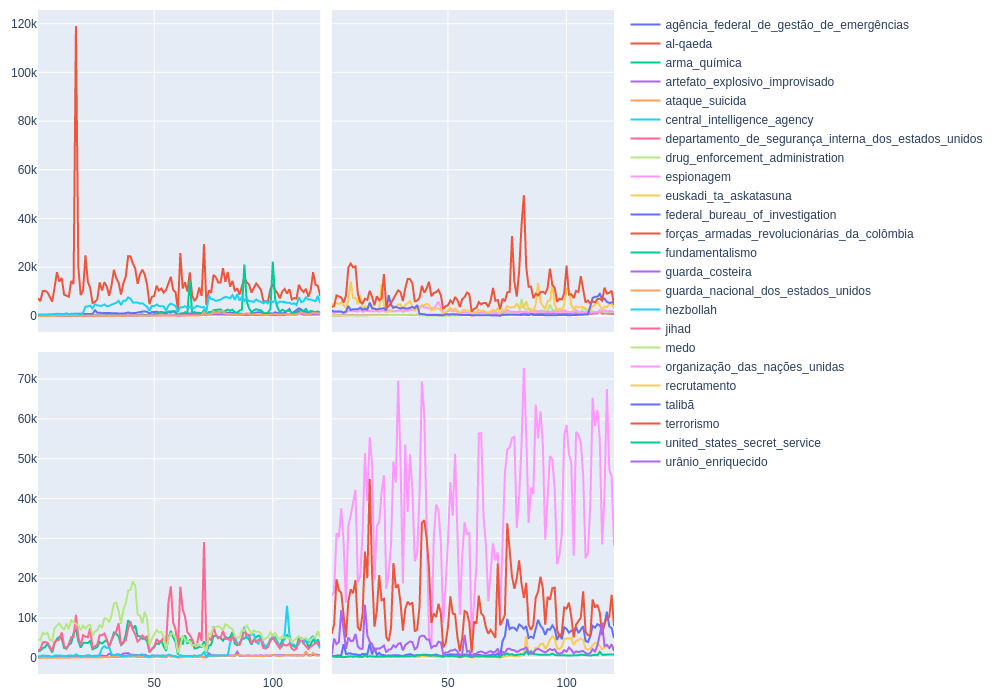

In [30]:
lang = 'pt'
four_panel_pageviews_plot(views[lang])

In [31]:
outliers[lang] = ['al-qaeda', 'arma_química', 'organização_das_nações_unidas', 'forças_armadas_revolucionárias_da_colômbia']

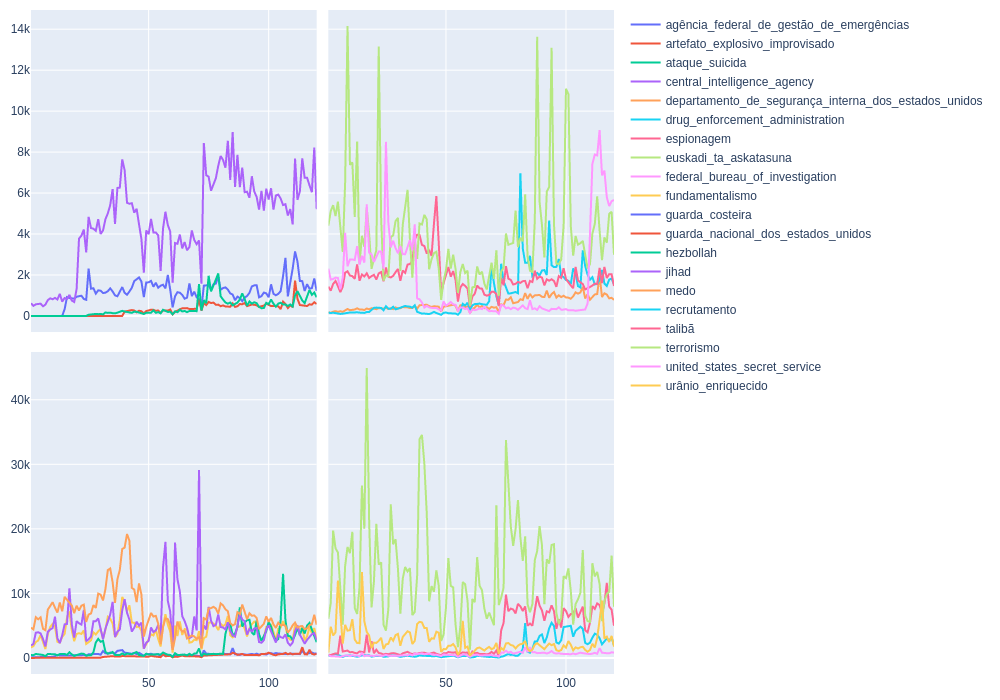

In [32]:
four_panel_pageviews_plot(views[lang], outliers[lang])

## Plotting the ITS analysis

Using the plotting function in `utils/plotly_plots`, we will thus produce the plots that will allow us to answer the research questions.

#### Are there chilling effects over the extended time range?

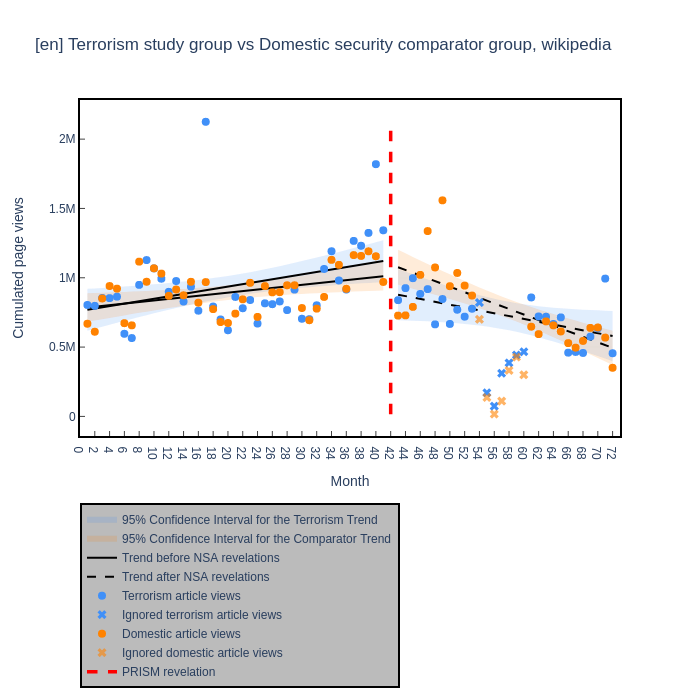

In [33]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='en', outliers=outliers, end_at=datetime.datetime(2015, 12, 31))
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_en_2015.html")

For completeness' sake, we also show the plot of the results if we used the full data from the API.

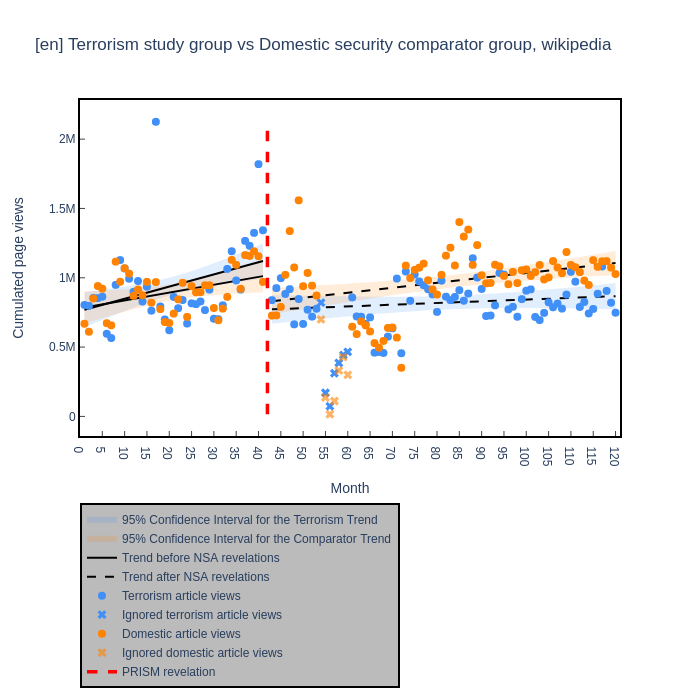

In [34]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='en', layout=wiki_layout, outliers=outliers)
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_en_2019.html")

#### What are the different patterns of chilling effects accros the different languages?

From here on, let's focus on the same time range as in the paper:

In [35]:
import dateutil.relativedelta
start, end = PAPER_TIME_RANGE
end = end

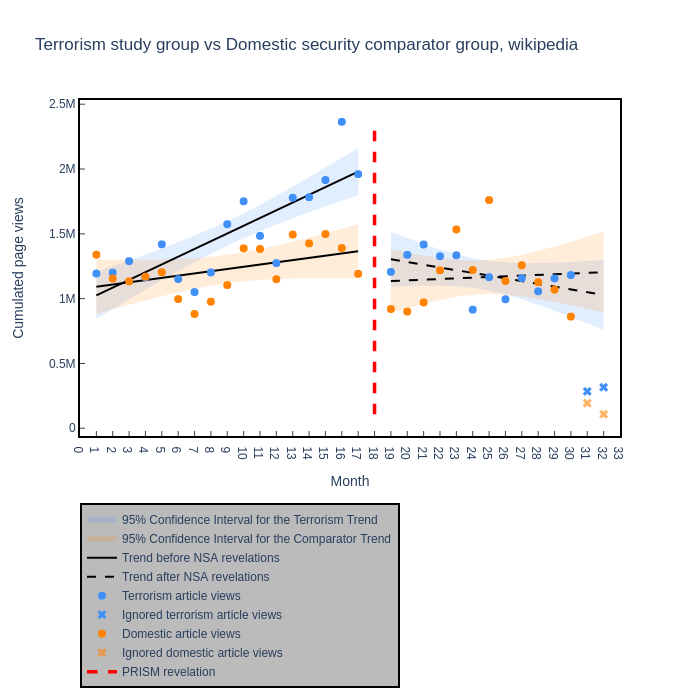

In [36]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, ignore_months=[31, 32], start_at=start, end_at=end, outliers=outliers)
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_all.html")

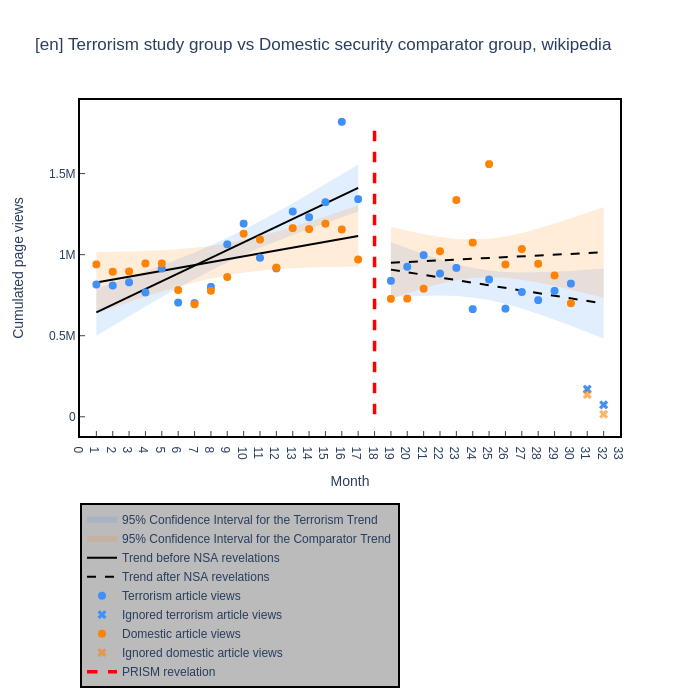

In [37]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='en', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_en.html")

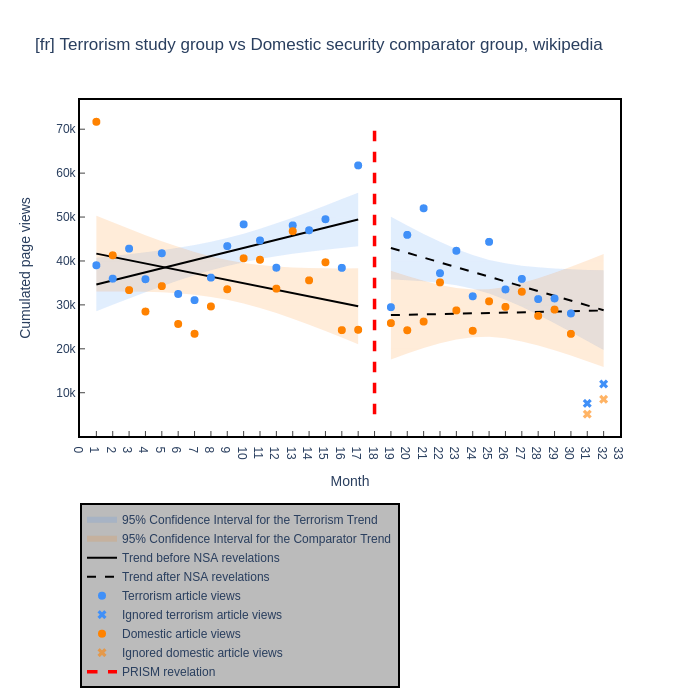

In [38]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='fr', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_fr.html")

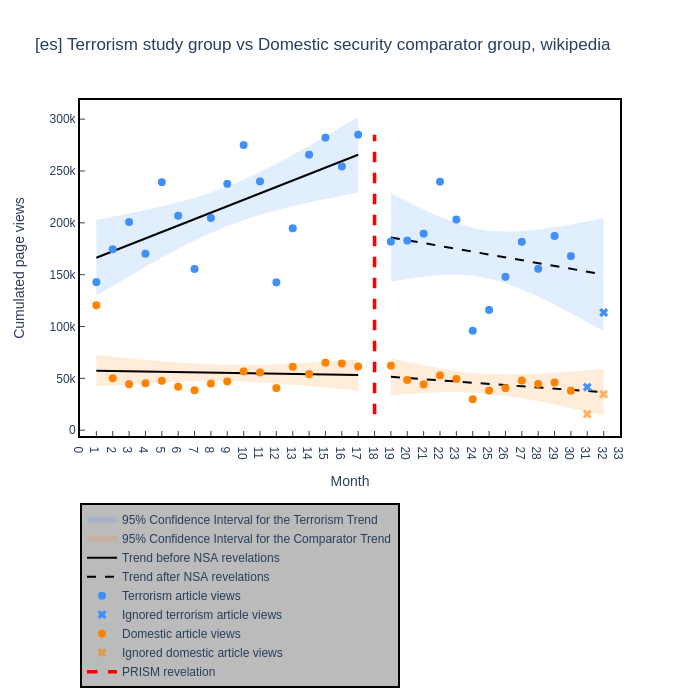

In [39]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='es', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_es.html")

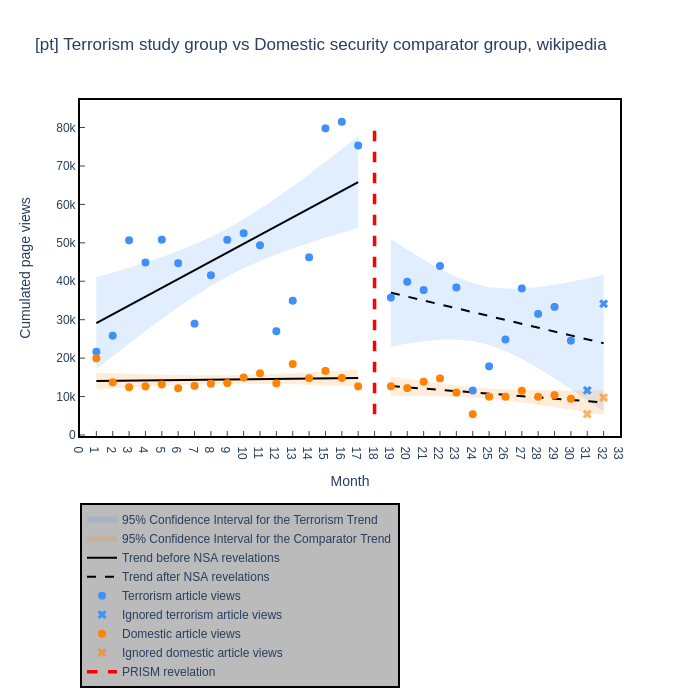

In [40]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='pt', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_pt.html")

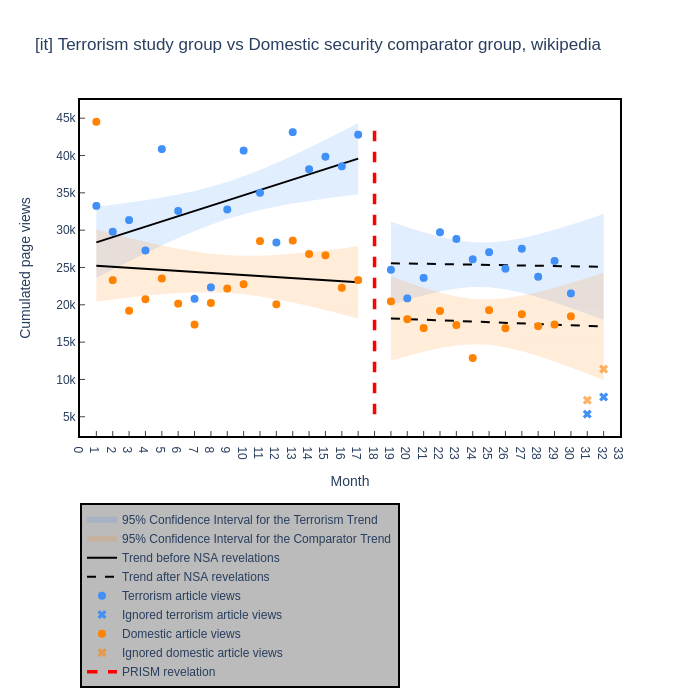

In [41]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='it', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_it.html")

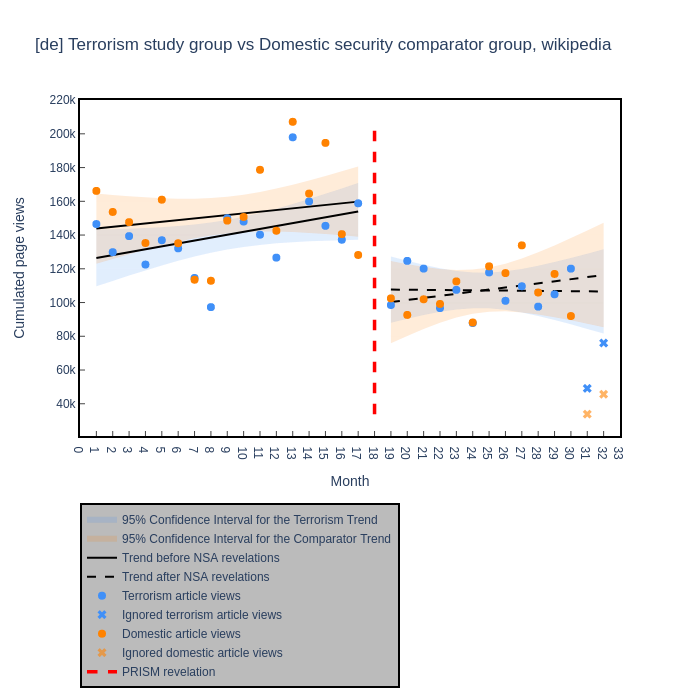

In [42]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout, lang='de', start_at=start, end_at=end, outliers=outliers, ignore_months=[31, 32])
fig.show('png', widht=1500, height=700)
fig.write_html("plots/wiki_de.html")

## Exploring the Google Trends Data

We queried Data from Google Trends from 2011 to 2015 for the same search terms we used for the Wikipedia Data. In the following, we will analyse them shortly and create the plots for our data story:

In [43]:
monthly_interest = google.groupby(['article', 'month', 'topic']).mean().reset_index().set_index('month')

In the following, we will have a look at the average google trends score of the different search terms queried from google trends. First, let's look at the Terror Dataset:

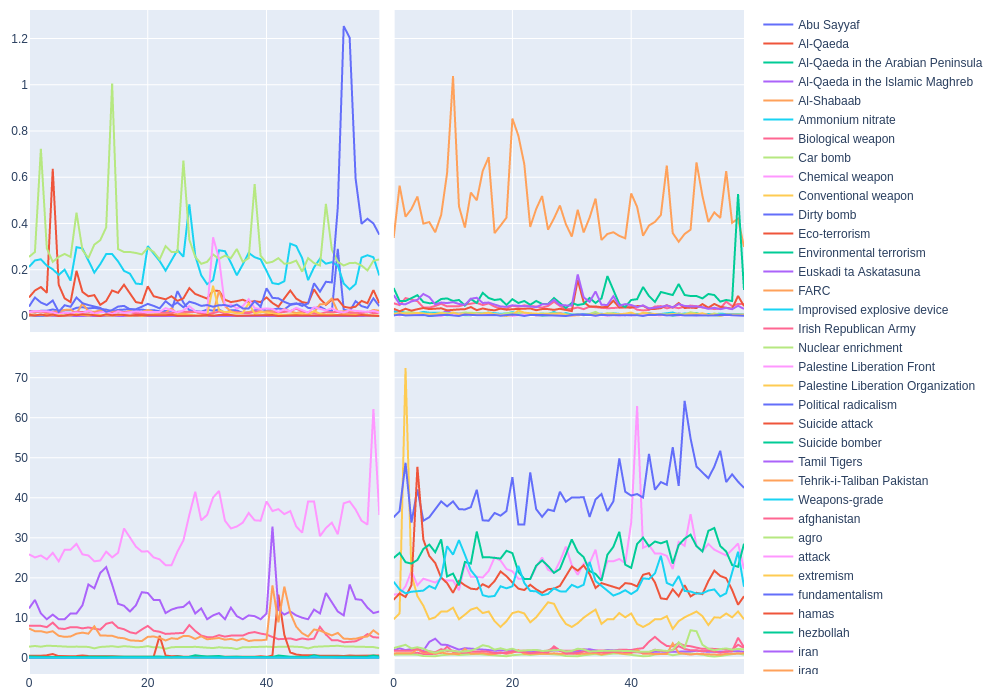

In [44]:
four_panel_google_plot(monthly_interest.loc[monthly_interest.topic == 'terror'])

The terrorism dataset looks good at first sight: There are no large gaps and no single months with a significant amount of individual peaks. There are two interesting peaks though, one for the term "Dirty Bomb" in month 54(July 2015) and one for "Nigeria" in month 41(June 2014). The peak for Dirty Bomb can be explained by the release of a computer game that goes by this name in Summer 2015. The rise in interest for Nigeria, especially in Google Searches, seems to be cause by the FIFA World Championship in June 2014. Both events let the search terms appear in searches about completely different content than usually, so we think it will be better to remove them from the analysis. How about the comparator dataset?

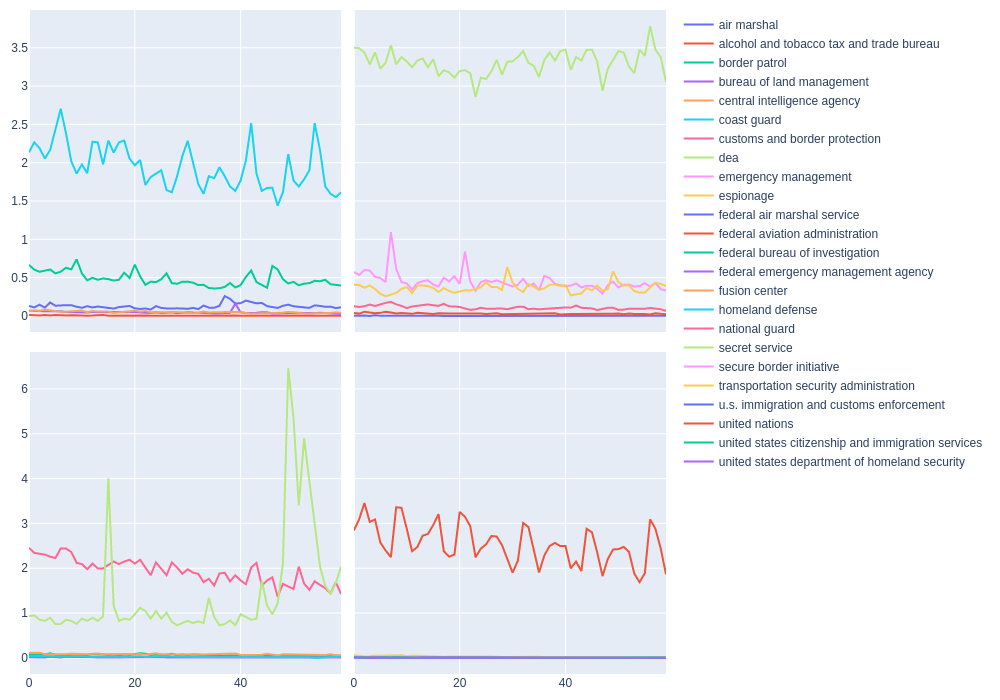

In [45]:
four_panel_google_plot(monthly_interest.loc[monthly_interest.topic == 'domestic'])

Most of the articles have a pretty constant trends score. The secret service article though has two significant peaks, the largest one at month 49 (February 2015). There doesn't seem to be a single event to cause such peaks - so we decided to drop this article from our analysis. It could be caused by an event beyond our knowledge or an anomaly in the Google Trends API - whatever it is, the overall trend will be preserved dropping it.

In [46]:
monthly_interest = monthly_interest.loc[monthly_interest.article!="secret service"]
monthly_interest = monthly_interest.loc[monthly_interest.article!="dirty bomb"]
monthly_interest = monthly_interest.loc[monthly_interest.article!="nigeria"]
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').mean()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').mean()

Now that we have an overview about the individual articles, let's cumulate them and see how the overall trend for both categories looks like:
**ATTENTION**: The following plot has two y-Axis to get the trends for Terrorism - and Domestic search terms in the same plot. Keep this in mind when watching it, they are not on the same scale.

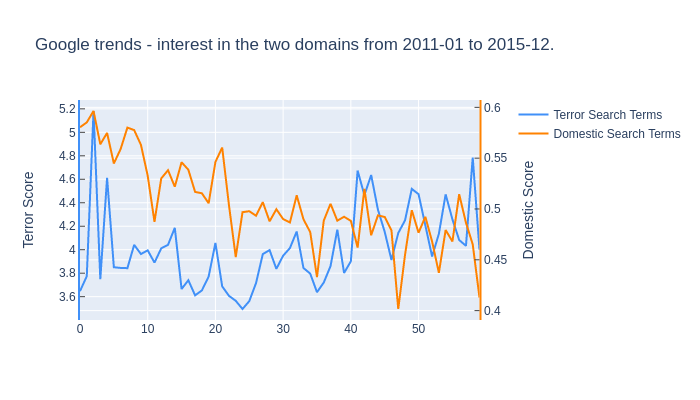

In [47]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=list(range(len(terror))), y=terror.max_ratio, name="Terror Search Terms", line_color='rgba(64,144,248,1)'))
fig.add_trace(go.Scatter(x=list(range(len(domestic))), y=domestic.max_ratio, name="Domestic Search Terms", line_color='rgba(255,130,0,1)'), secondary_y=True)
fig.update_layout(title="Google trends - interest in the two domains from {} to {}.".format(monthly_interest.index.min(), monthly_interest.index.max()))
fig.update_yaxes(nticks=10, ticks="inside", showline=True, linewidth=2, linecolor='rgba(64,144,248,1)', secondary_y=False, title="Terror Score")
fig.update_yaxes(nticks=10, ticks="inside", showline=True, linewidth=2, linecolor='rgba(255,130,0,1)', secondary_y=True, title="Domestic Score")
fig.show('png', widht=1000, height=400)

The data is alternating heavily, but we can see that it is doing so for both data sets. There seem to be no significant outliers, so we continue our analysis and see if we can observe a chilling effect. For a comparison with the original paper, we analyse two time frames. One for the whole available data set, one limited to the time range analyzed by Jonathon Penney in his Paper about chilling effects:

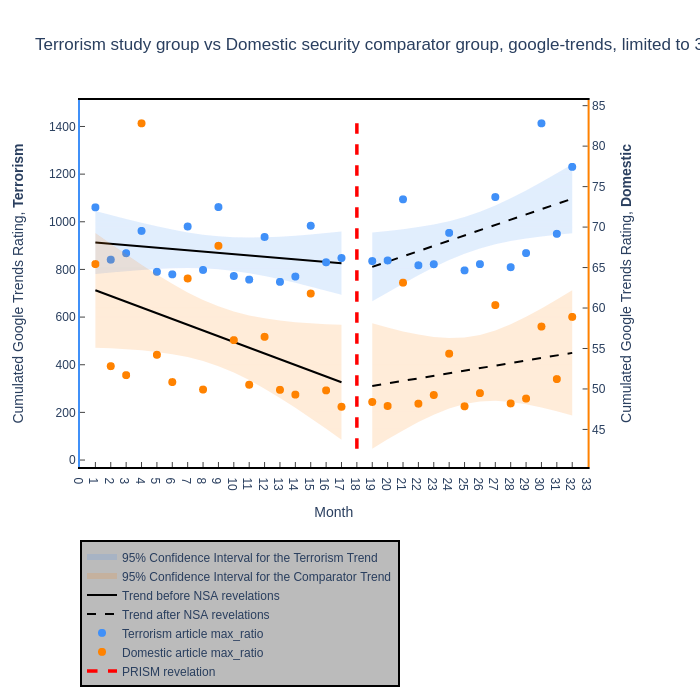

In [48]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('google-trends', ignore_months=[], layout=google_layout, seperate_y=True, start_at=start, end_at=end)
fig.update_layout(title="Terrorism study group vs Domestic security comparator group, google-trends, limited to 32 months")
fig.show('png', widht=1500, height=700)
fig.write_html('plots/google_trends_short.html')

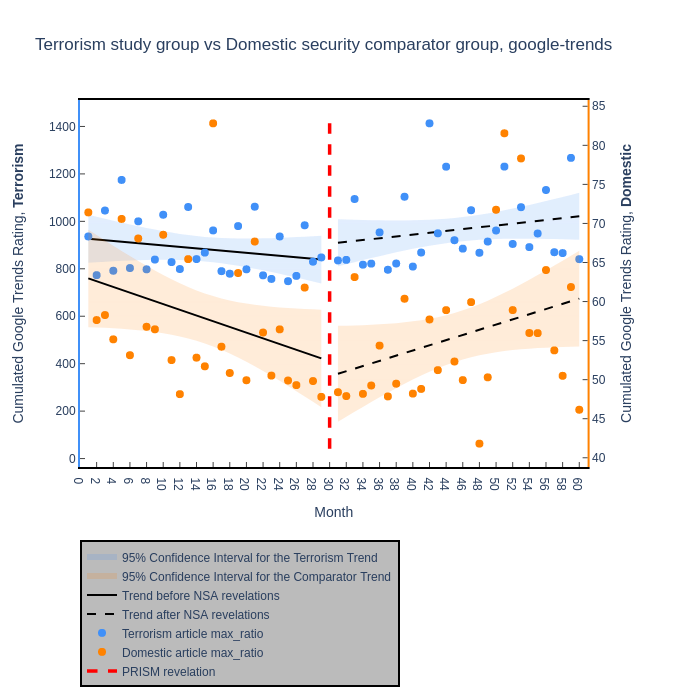

In [49]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('google-trends', ignore_months=[], layout=google_layout, seperate_y=True)
fig.show('png', widht=1500, height=700)
fig.write_html('plots/google_trends_long.html')

We see similar patterns for both time ranges: Although the terrorism search group has a higher overall Google Trends score(max_ratio), the trends of both groups are quite similar: For both groups, it seems that google searches for the groups actually increased after the PRISM revelations. As can be seen looking at the confidence interavals, this analysis does not suffice to prove the existence of an increased interest after June 2013. It does weaken the argument for the existence of chilling effects though, which are not visible at all in this visualisation.

## Conclusion

We have seen the trends for Wikipedia pageviews in multiple languages and Google Trends, both for different time ranges and two groups: one containing keywords related to terrorism and one comparator group with keywords from the domestic security.

The proper analysis of the results can be found in the according [data story](https://eliedz.github.io/).